# Train a new CNN 

### Imports

In [27]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
import random
import time

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow import keras

from tensorflow.python.keras.models import Sequential,Input,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

### Constants

In [13]:
IMG_SIZE = 48
MIN_BRIGHTNESS_PREDICTION = 50

PARENT_DIRECTORY = '../out3/'
FOLDER_NAME = '2022-07-29'

In [18]:
DRAW_PATHS = []
HOVER_PATHS = []

target_folder = os.path.join(PARENT_DIRECTORY, FOLDER_NAME)

subfolders = (next(os.walk(target_folder))[1])

for subfolder_name in subfolders:
    if 'draw' in subfolder_name:
        DRAW_PATHS.append(os.path.join(PARENT_DIRECTORY, FOLDER_NAME, subfolder_name))
    elif 'hover' in subfolder_name:
        HOVER_PATHS.append(os.path.join(PARENT_DIRECTORY, FOLDER_NAME, subfolder_name))
    else:
        print('ERROR: Malformed folder name')
        
print(DRAW_PATHS)
print(HOVER_PATHS)

['../out3/2022-07-29/draw_1_300', '../out3/2022-07-29/draw_0_300']
['../out3/2022-07-29/hover_far_0_300', '../out3/2022-07-29/hover_close_0_300']


### Helper functions

In [19]:
def read_images_mono(path):
    files = os.listdir(path)
    files = [file for file in files if file[-4:] == ".png"]
    
    images = []
    coords = []
    
    size = IMG_SIZE
    
    for file in tqdm(files):
        try:
            image = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
            if image.shape == (size, size) and np.max(image) > MIN_BRIGHTNESS_PREDICTION:
                images.append(image)
            
        except OSError:
            pass
    
    return images, coords

In [20]:
def data_augmentation(images):
    result = []
    for img in images:
        result.append(img)
        result.append(cv2.flip(img, flipCode=0))
        for i in range(3):  # TODO: CHECK IF 4 is needed here
            tmp = cv2.rotate(img, i)
            for b in range(9, 12):
                tmp2 = np.clip(tmp * (b / 10), 0, 255)
                result.append(tmp2)
                result.append(cv2.flip(tmp2, flipCode=0))
    return result

### Read in images and create additional images via Data Augmentation

In [21]:
images_draw = []
images_hover = []

for p in DRAW_PATHS:
    images_draw += read_images_mono(p)[0]
    
for p in HOVER_PATHS:
    images_hover += read_images_mono(p)[0]

images_draw = data_augmentation(images_draw)
images_hover = data_augmentation(images_hover)
images = images_draw + images_hover
labels = [0] * len(images_draw) + [1] * len(images_hover)

print(len(labels))

/tmp/ipykernel_71953/4281447985.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3489 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

214600


### Preview Data

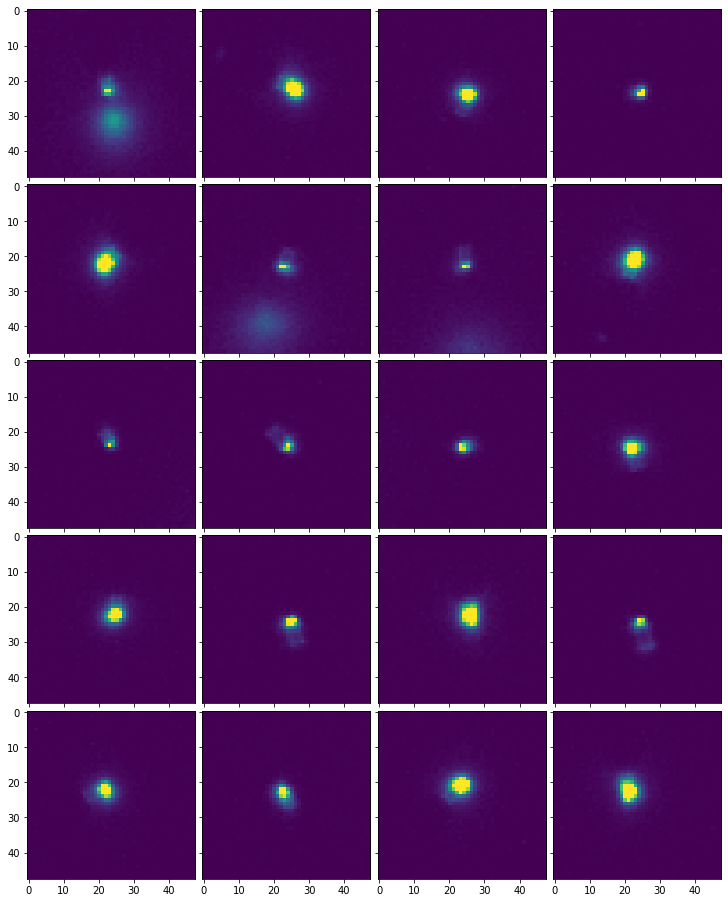

In [39]:
ROWS = 4
COLUMS = 5


image_list = []
for i in range(ROWS*COLUMS):
    image_list.append(random.sample(images, 1)[0])


fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(COLUMS, ROWS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, image_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

### Prepare Training and Validation Data

In [40]:
train_X = np.array(images)
train_Y = np.array(labels)

print('Training data shape : ', train_X.shape, train_Y.shape)

train_X = train_X.astype('float32')
train_X = train_X / 255.

train_Y_one_hot = to_categorical(train_Y)

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

train_X = train_X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(train_X.shape, valid_X.shape, train_label.shape, valid_label.shape)

unique, counts = np.unique(valid_label, return_counts=True)
dict(zip(unique, counts))

Training data shape :  (214600, 48, 48) (214600,)
(171680, 48, 48, 1) (42920, 48, 48) (171680, 2) (42920, 2)


{0.0: 42920, 1.0: 42920}

### Start Training

In [46]:
#Settings

# batch 64
# epoch 1
# conv linear

batch_size = 32
epochs = 1
num_classes = 2
activation = 'relu'
activation_conv = 'relu'
layer_count = 5
num_neurons = 128

#for epochs in range(1, 7):
    #print(f'+++++ EPOCHS: {epochs} +++++')
#Define model structure
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 1),activation=activation_conv,input_shape=(IMG_SIZE,IMG_SIZE,1),padding='same'))
model.add(Conv2D(64, (1, 3), activation=activation_conv,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(32, (3, 1), activation=activation_conv,padding='same'))
model.add(Conv2D(32, (1, 3), activation=activation_conv,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(32, (3, 3), activation=activation_conv,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))                 
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())

# trial and error: linear performs much better than ReLU and sigmoid
for i in range(layer_count):
    model.add(Dense(num_neurons, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(128, activation='linear'))
#model.add(Dense(128, activation='linear'))

# classifier
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.metrics.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

history = model.fit(
    train_X, 
    train_label, 
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label)
)

2022-07-29 20:57:39.839914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 20:57:39.840065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vigitia/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib:/home/vigitia/ros2_galactic/ros2-linux/opt/yaml_cpp_vendor/lib:/home/vigitia/ros2_galactic/ros2-linux/opt/rviz_ogre_vendor/lib:/home/vigitia/ros2_galactic/ros2-linux/lib
2022-07-29 20:57:39.840109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

5365/5365 [==============================] - 279s 52ms/step - loss: 0.0485 - accuracy: 0.9827 - val_loss: 0.0197 - val_accuracy: 0.9959


In [56]:
loss = print(history.history['loss'])
val_loss = print(history.history['val_loss'])
accuracy = print(history.history['accuracy'])
val_accuracy = print(history.history['val_accuracy'])

[0.04847075790166855]
[0.019687170162796974]
[0.9827236533164978]
[0.9958550930023193]


### Save the Model

In [47]:
MODEL_NAME = 'model_new_projector_1'

if MODEL_NAME in next(os.walk('.'))[1]:
    print('Warning: There already exists a model called "{}"'.format(MODEL_NAME))
    print('Make sure you want to overwrite it before it gets saved!')
else:
    model.save(MODEL_NAME)

INFO:tensorflow:Assets written to: model_new_projector_1/assets


INFO:tensorflow:Assets written to: model_new_projector_1/assets
